In [1]:
import pathlib
import pandas as pd
import pickle as pkl
import numpy as np
from icecream import ic
import sys
import os

In [2]:
from compute_full_df import get_acc

sys.path.append(os.path.abspath("../"))
from utils import get_rank_corrs, plot_rank_corrs, aggregate_rank_corrs

In [3]:
sys.path.append(os.path.abspath("../../"))
from paths import resources_path

scores_path = resources_path / pathlib.Path("scores/pca_deletion/scores.pkl")
full_df_path = resources_path / pathlib.Path("full_dfs/pca_deletion/full_df.csv")
# full_df_path = resources_path / pathlib.Path("full_dfs/pca_deletion/full_df_self_computed.csv")

# Load `full_df`

In [4]:
full_df = pd.read_csv(full_df_path)

# Dataset subsetting

In [5]:
REF_SEEDS = [1,2,3,4,5,6,7]
def pca_sub_df(df, task, ref_depth):
    # find best seed for the task: reference seed
    data_dict = pkl.load(open(scores_path, "rb")) # TODO: this seems weird - scores_path leads to a csv file
    accs = [get_acc(data_dict, probe_task, seed, layer=ref_depth, dims=0, run='average') for seed in REF_SEEDS]
    acc_dict = dict(zip(REF_SEEDS, accs))
    best_seed = max(acc_dict, key=acc_dict.get)

    # select rows of full_df corresponding to the reference layer (layer depth and seed)
    sub_df = df[(df.layer1 == ref_depth) & (df.layer2 == ref_depth) & ((df.seed1 == best_seed) | (df.seed2 == best_seed))]

    return sub_df

# Rank correlation results

In [6]:
probe_task = "SST-2"
METRICS = ["Procrustes", "CKA", "PWCCA"]
num_layers = 12
LAYERS=[7,8,9,10,11]

In [7]:
rho, rho_p, tau, tau_p, bad_fracs = aggregate_rank_corrs(full_df, 
                                                            probe_task, 
                                                            num_layers, 
                                                            METRICS, 
                                                            pca_sub_df, 
                                                            list_layers = LAYERS)

In [8]:
# average all of these over the different reference layers
for metric in METRICS:
    avg_rho = round(np.mean(rho[metric]), 3)
    avg_rho_p = format(np.mean(rho_p[metric]), ".1e")
    avg_tau = round(np.mean(tau[metric]), 3)
    avg_tau_p = format(np.mean(tau_p[metric]), ".1e")
    avg_bad_frac = round(np.mean(bad_fracs[metric]), 3)

    ic(metric, avg_rho, avg_rho_p, avg_tau, avg_tau_p, avg_bad_frac)

ic| metric: 'Procrustes'
    avg_rho: 0.86
    avg_rho_p: '4.8e-37'
    avg_tau: 0.677
    avg_tau_p: '3.6e-30'
    avg_bad_frac: 0.001
ic| metric: 'CKA'
    avg_rho: 0.751
    avg_rho_p: '6.4e-26'
    avg_tau: 0.564
    avg_tau_p: '8.9e-23'
    avg_bad_frac: 0.002
ic| metric: 'PWCCA'
    avg_rho: 0.87
    avg_rho_p: '6.8e-39'
    avg_tau: 0.69
    avg_tau_p: '2.3e-31'
    avg_bad_frac: 0.001


ic| metric: 'Procrustes'
    avg_rho: 0.848
    avg_rho_p: '6.4e-35'
    avg_tau: 0.662
    avg_tau_p: '2.2e-28'
    avg_bad_frac: 0.001
ic| metric: 'CKA'
    avg_rho: 0.779
    avg_rho_p: '3.0e-28'
    avg_tau: 0.609
    avg_tau_p: '3.7e-24'
    avg_bad_frac: 0.004
ic| metric: 'PWCCA'
    avg_rho: 0.867
    avg_rho_p: '5.1e-38'
    avg_tau: 0.683
    avg_tau_p: '7.1e-31'
    avg_bad_frac: 0.001

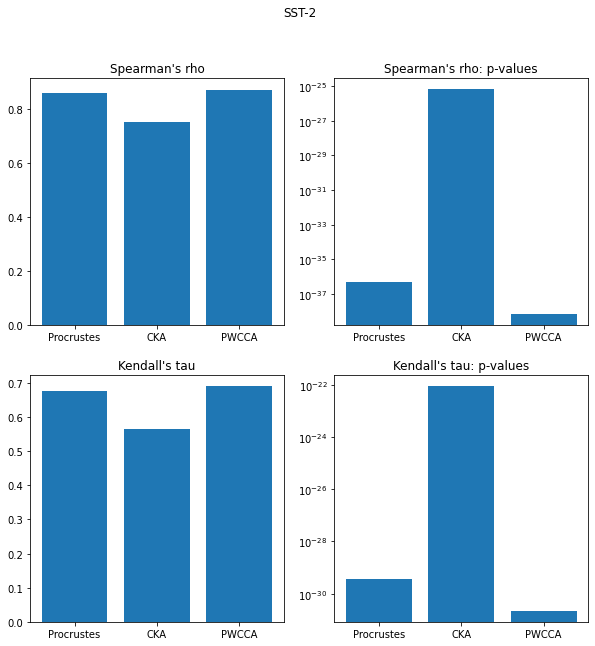

In [9]:
plot_rank_corrs(rho, rho_p, tau, tau_p, METRICS, title = probe_task)